In [1]:
%cd ..
import os
import numpy as np
import pandas as pd

from utils.utils_notebook import get_MI_df, get_DTI_rank_df, get_loss_df, LATEX_FIG_PATH
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
METRIC = r"$\overline{\mathcal{I}_S}$"
warnings.filterwarnings("ignore")

/home/philippe/InfEmb/emir/molecule


2024-05-21 09:46:20,765 - main - INFO - Logger is set.


# Downstream Eval

In [2]:
df = get_MI_df("ZINC", results_dir_list=["run_4"])
df_downs = get_DTI_rank_df(df, metric=f"clustering_l2_4",dataset="KIBA",order="ascending")
df


100%|██████████| 1/1 [00:00<00:00, 25.19it/s]


,X,Y,I(Y),I(Y|X),I(X->Y),I(X),Y_dim,X_dim,cond_modes,marg_modes,ff_layers,ff_hidden_dim,batch_size,I(Y->X),I(X->Y)/dim,I(Y->X)/dim
0,DenoisingPretrainingPQCMv4,ContextPred,99.895386,-16.167234,116.062620,0.0,300,256,4,4,2,512,1024,50.239949,0.386875,0.196250
1,DenoisingPretrainingPQCMv4,GPT-GNN,264.500923,110.157674,154.343249,0.0,300,256,4,4,2,512,1024,61.080045,0.514477,0.238594
2,DenoisingPretrainingPQCMv4,GraphMVP,384.809479,79.445650,305.363829,0.0,300,256,4,4,2,512,1024,87.178994,1.017879,0.340543
3,DenoisingPretrainingPQCMv4,GROVER,379.846327,106.535473,273.310854,0.0,300,256,4,4,2,512,1024,79.041889,0.911036,0.308757
4,DenoisingPretrainingPQCMv4,AttributeMask,331.514773,35.877839,295.636934,0.0,300,256,4,4,2,512,1024,66.096862,0.985456,0.258191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,ThreeDInfomax,MolR_gcn,1314.046801,319.338781,994.708020,0.0,1024,800,4,4,2,512,1024,825.262965,0.971395,1.031579
24,ThreeDInfomax,MolR_tag,1308.882363,385.024174,923.858189,0.0,1024,800,4,4,2,512,1024,842.567016,0.902205,1.053209
25,ThreeDInfomax,MoleOOD_OGB_GIN,243.215791,59.627813,183.587977,0.0,256,800,4,4,2,512,1024,513.174536,0.717141,0.641468
26,ThreeDInfomax,MoleOOD_OGB_GCN,264.184007,40.542053,223.641953,0.0,256,800,4,4,2,512,1024,576.844889,0.873601,0.721056


In [3]:
%matplotlib inline


def plot_corr(df, REMOVE_MODELS=[], FIGSIZE = 3, title="", DATASET="Kiba"):
    fig, axes = plt.subplots(2,2, figsize=(FIGSIZE*2,FIGSIZE*2), sharex=True, sharey=False)
    axes = axes.flatten()
    key = "clustering_l2_"


    for i,n_clus in enumerate([1,2,4,8]):
        if "l2" in key:
            end = "(reg)"
            df_downs = get_DTI_rank_df(df, metric=f"{key}{n_clus}",dataset=DATASET,order="ascending")
        else:
            end = "(clas)"
            df_downs = get_DTI_rank_df(df, metric=f"{key}{n_clus}")
        df_downs = df_downs[~df_downs.embedder.isin(REMOVE_MODELS)]
        df_tmp = df_downs.groupby("embedder").mean()
        sns.scatterplot(data=df_tmp, y="meanrank_metric", x="meanrank_information", hue="embedder", ax=axes[i], legend=False, style="embedder",)
        sns.regplot(data=df_tmp, y="meanrank_metric", x="meanrank_information", ax=axes[i], scatter=False, color="blue", line_kws = {"alpha":0.2})

        # Display the correlation coefficient
        corr = df_tmp[["meanrank_metric", "meanrank_information"]].corr("spearman").iloc[0,1]
        corr_kendall = df_tmp[["meanrank_metric", "meanrank_information"]].corr("kendall").iloc[0,1]
        corr_p = -df_tmp[[f"{key}{n_clus}", "information"]].corr("pearson").iloc[0,1]
        axes[i].text(
            0.8,
            0.2,
             f"\nR: {corr_p:.2f}\n" + r"$\rho_s $" + f": {corr:.2f}\n " +r"$\tau $: "+f"{corr_kendall:.2f}",
            horizontalalignment='center',
            verticalalignment='center',
            transform=axes[i].transAxes
        )
        axes[i].set_title("$n_{neighbors}$ = "+f"{n_clus}")

        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

        #remove x/yticks
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    fig.supylabel(f"Local agreement rank")
    fig.supxlabel(f"{METRIC} rank")
    fig.suptitle(title)


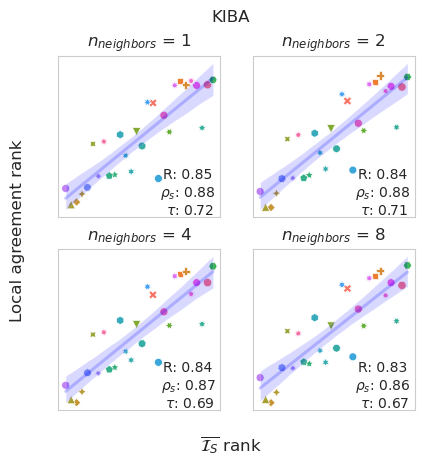

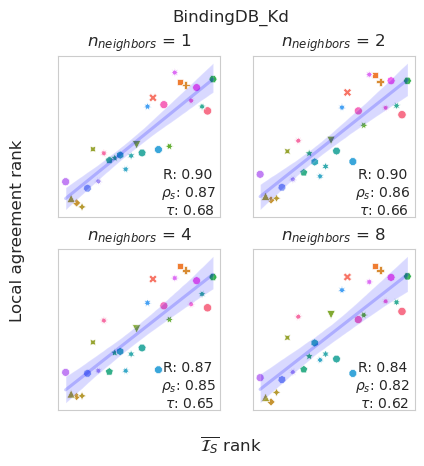

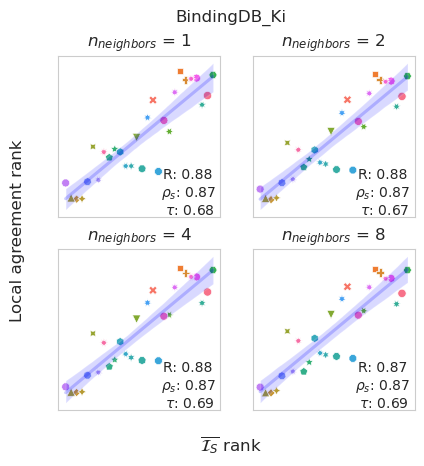

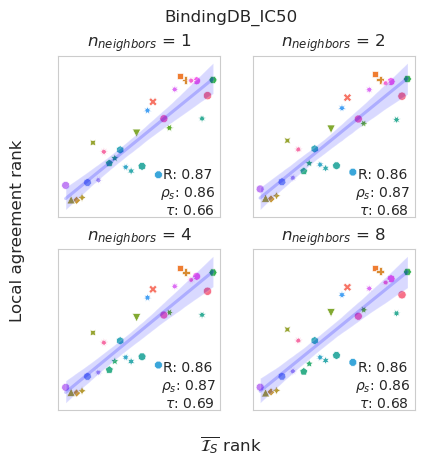

In [7]:
DATASET="KIBA"
for DATASET in ["KIBA", "BindingDB_Kd", "BindingDB_Ki", "BindingDB_IC50"]:
    plot_corr(df, title=f"{DATASET}", FIGSIZE=2.3, DATASET=DATASET)
    plt.savefig(f"{LATEX_FIG_PATH}/molecule/DTI_all_res_{DATASET}.pdf", format = "pdf", bbox_inches = 'tight')
    plt.show()

In [9]:
import pandas as pd
import numpy as np
from autorank import autorank

def compute_ranking(df_downs, dataset="Overall", type_metric="reg", n_neighb=-1):
    df_downs_linearized = []
    for col in df_downs.columns:
        if "clustering" in col:
            df_tmp = df_downs[["embedder", "dataset", "target", col]].rename(columns={col:"metric"})
            df_tmp["n_neighb"] = int(col.split("_")[-1])
            if "l2" in col:
                df_tmp["type"] = "reg"
                df_tmp.metric = 1-df_tmp.metric
            else:
                df_tmp["type"] = "cls"
            df_downs_linearized.append(df_tmp)
    df_downs_linearized = pd.concat(df_downs_linearized)

    if type_metric!="all":
        df_downs_linearized = df_downs_linearized[df_downs_linearized["type"] == type_metric]
    if n_neighb != -1:
        df_downs_linearized = df_downs_linearized[df_downs_linearized["n_neighb"] == n_neighb]

    df_to_rank = df_downs_linearized.pivot_table(index=["n_neighb", "type",  "dataset", "target"], columns="embedder", values="metric")

    res = autorank(
        df_to_rank,
        alpha=0.05,
        verbose=False,
        force_mode="nonparametric"
    ).rankdf.meanrank.to_frame()
    res = res.rename(columns={"meanrank":dataset})
    return res





In [11]:
df_plot = None

DATASETS = ["BindingDB_IC50","BindingDB_Ki", "BindingDB_Kd","KIBA"]

for dataset in DATASETS:
    df_downs = get_DTI_rank_df(df, order="ascending", dataset=dataset)
    res = compute_ranking(df_downs, dataset)
    if df_plot is None:
        df_plot = res
    else:
        df_plot = df_plot.join(res)


df_downs =  pd.concat(
    [
        get_DTI_rank_df(
            df, order="ascending", dataset=dataset
        ) for dataset in DATASETS
    ]
)
res = compute_ranking(df_downs)
df_plot = df_plot.join(res)

df_plot = df_plot.join(df_downs.groupby("embedder").mean().rename(columns={"meanrank_information":METRIC})[[METRIC]])
df_plot

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


,BindingDB_IC50,BindingDB_Ki,BindingDB_Kd,KIBA,Overall,$\overline{\mathcal{I}_S}$
embedder,,,,,,
ChemBertMLM-5M,24.322354,24.420822,23.380952,23.654286,24.255275,22.0
ChemBertMLM-77M,23.682775,23.534704,22.714286,24.071429,23.677914,23.0
ContextPred,23.668332,24.067722,22.464286,24.621429,23.862358,28.0
MoleOOD_OGB_GIN,23.105427,23.150606,22.023810,22.650000,23.048058,25.0
MoleOOD_OGB_SAGE,22.758099,23.080526,18.928571,21.664286,22.656145,24.0
MoleOOD_OGB_GCN,21.691685,21.389825,22.654762,23.182857,21.805007,21.0
ChemBertMLM-10M,20.875540,20.764488,21.357143,20.602857,20.822756,17.0
AttributeMask,20.768494,20.713949,17.857143,22.541429,20.921802,27.0
MolBert,19.514984,18.634771,19.202381,21.387143,19.511303,16.0


In [12]:
avg_results = df_plot.reset_index().rename(columns={"embedder":"model"})

def prerpocess_emb_name(x):
    return x.replace(
        "DenoisingPretrainingPQCMv4",
        "3D-denoising"
    ).replace(
        "Chem",
        ""
    ).replace(
        "ThreeDInfomax",
        "3D-Infomax"
    ).replace(
        "_OGB",
        ""
    )

avg_results.model = avg_results.model.apply(prerpocess_emb_name)
avg_results

,model,BindingDB_IC50,BindingDB_Ki,BindingDB_Kd,KIBA,Overall,$\overline{\mathcal{I}_S}$
0,BertMLM-5M,24.322354,24.420822,23.380952,23.654286,24.255275,22.0
1,BertMLM-77M,23.682775,23.534704,22.714286,24.071429,23.677914,23.0
2,ContextPred,23.668332,24.067722,22.464286,24.621429,23.862358,28.0
3,MoleOOD_GIN,23.105427,23.150606,22.023810,22.650000,23.048058,25.0
4,MoleOOD_SAGE,22.758099,23.080526,18.928571,21.664286,22.656145,24.0
5,MoleOOD_GCN,21.691685,21.389825,22.654762,23.182857,21.805007,21.0
6,BertMLM-10M,20.875540,20.764488,21.357143,20.602857,20.822756,17.0
7,AttributeMask,20.768494,20.713949,17.857143,22.541429,20.921802,27.0
8,MolBert,19.514984,18.634771,19.202381,21.387143,19.511303,16.0
9,GPT-GNN,17.341388,19.110175,19.142857,16.002857,17.649364,26.0


In [27]:
df_downs

,Unnamed: 0,embedder,target,dataset,length,clustering_1,clustering_l2_1,clustering_2,clustering_l2_2,clustering_4,clustering_l2_4,clustering_8,clustering_l2_8,information,cond_modes,meanrank_metric,meanrank_information
0,0,ContextPred,P07711,BindingDB_IC50,1024,0.767643,0.765785,0.751997,0.834612,0.719707,0.932666,0.688915,1.048053,0.347952,4,7.150648,28.0
1,1,ContextPred,P80457,BindingDB_IC50,1024,0.861042,0.569477,0.852978,0.625805,0.830025,0.715142,0.799163,0.835421,0.347952,4,7.150648,28.0
2,2,ContextPred,O42713,BindingDB_IC50,1024,0.735818,0.874937,0.698541,1.023753,0.652755,1.173089,0.605551,1.325083,0.347952,4,7.150648,28.0
3,3,ContextPred,P23978,BindingDB_IC50,1024,0.916168,0.346872,0.904192,0.421440,0.884731,0.511706,0.841317,0.618034,0.347952,4,7.150648,28.0
4,4,ContextPred,P31649,BindingDB_IC50,1024,0.829114,0.285302,0.781646,0.354399,0.738924,0.391158,0.708861,0.442374,0.347952,4,7.150648,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,4895,ThreeDInfomax,Q9H3Y6,KIBA,1024,1.000000,0.003565,1.000000,0.003551,1.000000,0.003482,1.000000,0.003486,0.868448,4,15.834286,8.0
4896,4896,ThreeDInfomax,Q9NR20,KIBA,1024,0.997890,0.005418,0.997890,0.006496,0.996835,0.007071,0.997099,0.007595,0.868448,4,15.834286,8.0
4897,4897,ThreeDInfomax,Q9UEE5,KIBA,1024,0.998073,0.015803,0.998073,0.018093,0.998073,0.020307,0.997832,0.021071,0.868448,4,15.834286,8.0
4898,4898,ThreeDInfomax,Q9Y6M4,KIBA,1024,0.986985,0.009657,0.991323,0.010563,0.992950,0.011731,0.992679,0.012498,0.868448,4,15.834286,8.0


In [28]:
df_downs_all_concat = pd.concat(
    [
        df_downs[[f"clustering_l2_{n}", "dataset", "target", "information"]].rename(columns={f"clustering_l2_{n}":f"value"}) for n in [1]
    ], ignore_index=True
)
df_downs_all_concat

,value,dataset,target,information
0,0.765785,BindingDB_IC50,P07711,0.347952
1,0.569477,BindingDB_IC50,P80457,0.347952
2,0.874937,BindingDB_IC50,O42713,0.347952
3,0.346872,BindingDB_IC50,P23978,0.347952
4,0.285302,BindingDB_IC50,P31649,0.347952
...,...,...,...,...
41883,0.003565,KIBA,Q9H3Y6,0.868448
41884,0.005418,KIBA,Q9NR20,0.868448
41885,0.015803,KIBA,Q9UEE5,0.868448
41886,0.009657,KIBA,Q9Y6M4,0.868448


In [32]:
# make mosaic map
%matplotlib inline

def plot_glob_mosaic(avg_results, METRIC=METRIC, MODEL_TO_ANNOATE = set(["3D-Infomax", "InfoGraph", "MolBert", "BertMTR-5M", "GraphCL", "Not-trained"]), MODEL_TO_ANNOATE_left = set(), FIGSIZE=5):
    mosaic_map = [
        ['A', 'A', 'B', 'C'],
        ['A', 'A', 'D', 'E'],
    ]

    mosaic_to_task_map = {
        'A': 'Overall',
        'B': 'BindingDB_Kd',
        'C': 'BindingDB_Ki',
        'D': 'BindingDB_IC50',
        'E': 'KIBA',
    }

    mosaic_map = np.array(mosaic_map)
    mosaic_map = np.vectorize(lambda x: mosaic_to_task_map[x])(mosaic_map)



    fig, ax = plt.subplot_mosaic(mosaic_map, figsize=(FIGSIZE, FIGSIZE * 1.7/3), gridspec_kw={"width_ratios": [1,1, 1, 1],})
    METRICS = mosaic_to_task_map.values()
    for i, metric in enumerate(METRICS):
        if metric == "Overall":
            s = 100
        else:
            s = 50
        ax[metric] = sns.regplot(data=avg_results, y=METRIC, x=metric, ax=ax[metric], scatter=False)
        ax[metric] = sns.scatterplot(data=avg_results, y=METRIC, x=metric, ax=ax[metric], legend=False, hue = 'model', style='model', s=s)


        # annotate model names
        if metric == 'Overall':
            for i, row in avg_results.iterrows():
                xy = (row[metric], row[METRIC])
                if row['model'] in MODEL_TO_ANNOATE:
                    xytext = (9.5,-9.5)
                    ax[metric].annotate(
                        row['model'],
                        xy,
                        fontsize=10,
                        va='center',
                        ha='left',
                        textcoords='offset points',
                        xytext=xytext,
                        arrowprops=dict(
                            facecolor='black',
                            color='black',
                            arrowstyle='->',
                            connectionstyle='arc3,rad=0.2'
                        )
                    )
                elif row["model"] in MODEL_TO_ANNOATE_left:
                    xytext = (-65.5,10.5)
                    ax[metric].annotate(
                        row['model'],
                        xy,
                        fontsize=10,
                        va='center',
                        ha='left',
                        textcoords='offset points',
                        xytext=xytext,
                        arrowprops=dict(
                            facecolor='black',
                            color='black',
                            arrowstyle='->',
                            connectionstyle='arc3,rad=0.2'
                        )
                    )

        # annotate correllation
        corr = avg_results[[METRIC, metric]].corr(method="spearman").iloc[0, 1]
        kendall = avg_results[[METRIC, metric]].corr(method="kendall").iloc[0, 1]
        if metric != 'Overall':
            pearson = df_downs_all_concat[df_downs_all_concat.dataset == metric][["value", "information"]].corr("pearson").iloc[0, 1]
        else:
            pearson = df_downs_all_concat[["value", "information"]].corr("pearson").iloc[0, 1]
        if metric != 'Overall':
            ax[metric].annotate(
                r"$\rho_s$" + f": {corr:.2f}\n" + r" $\tau$" + f": {kendall:.2f}",
                (0.55, 0.05),
                xycoords='axes fraction',
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
            )
        else:
            ax[metric].annotate(
                r"$\rho_s$" + f": {corr:.2f}\n" + r" $\tau$" + f": {kendall:.2f}",
                (0.75, 0.1),
                xycoords='axes fraction',
                fontsize=12,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
            )

        if metric == 'Overall':
            ax[metric].set_title(metric, fontweight='bold')
            ax[metric].set_ylabel(METRIC + "  " + r"$(rank\downarrow)$")
            ax[metric].set_xlabel('Downstream tasks  $(rank\downarrow)$')
        else:
            ax[metric].set_title(metric.replace('Average', '').replace("(", "\n("), fontsize=10,)
            ax[metric].set_xlabel('')
            ax[metric].set_ylabel('')
            ax[metric].set_xticks([])
            ax[metric].set_yticks([])


    fig.tight_layout()

    plt.savefig(f"{LATEX_FIG_PATH}/molecule/meanrank_DTI_all.pdf", format = "pdf", bbox_inches = 'tight')


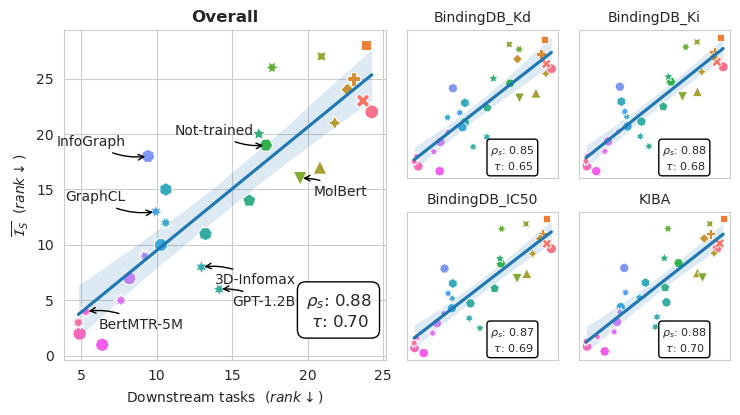

In [33]:

plot_glob_mosaic(
    avg_results,
    METRIC=METRIC,
    MODEL_TO_ANNOATE = set(["3D-Infomax", "GPT-1.2B", "MolBert", "BertMTR-5M",]),
    MODEL_TO_ANNOATE_left = set(["GraphCL", "Not-trained", "InfoGraph"]),
    FIGSIZE=7.5
)